In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from itertools import combinations
import glob
import yake
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
from sklearn.metrics import cohen_kappa_score

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /scratch4/mdredze1/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /scratch4/mdredze1/nltk_cache...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
output_dir = os.environ.get('READABILITY_ANALYSIS_DATASET_DIR')
dataset_dir = os.environ.get('DATASET_DIR')

In [4]:
output_files = glob.glob(f"{output_dir}/meta-llama/Llama-3.3-70B-Instruct.*.csv")

In [5]:
def get_summaries(d_name):
    f_name = f'{dataset_dir}/{d_name}.target'
    lines = open(f_name).readlines()
    return [l.strip() for l in lines]

In [6]:
def get_scores(files_list):
    objs = []
    for f_name in files_list:
        df = pd.read_csv(f_name)
        try:
            scores = df['reading_ease'].to_list()
            responses = df['response'].to_list()
            dataset = f_name.split('.')[-2]
            summaries = get_summaries(dataset)
            model = f_name.split('.')[-3]
            objs.append(
                pd.DataFrame.from_dict(
                    {
                    'readability': scores, 
                    'summary': summaries,
                    'response': responses, 
                    'dataset': dataset, 
                    'model': model})
            )
        except KeyError:
            print(f_name)
    return pd.concat(axis=0, ignore_index=True, objs=objs)
all_scores = get_scores(output_files)
all_scores

,readability,summary,response,dataset,model
0,2.0,"Significance Endothelial cells ( ECs) , which ...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct
1,1.0,Significance Epithelial cellular activating mo...,I would rate the reading ease of this text as ...,cells,3-70B-Instruct
2,2.0,Significance Approximately 25% of the human pr...,I would rate the reading ease of this text as ...,cells,3-70B-Instruct
3,2.0,"All cell types have a characteristic size, but...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct
4,2.0,"Significance Processing of spatial, temporal, ...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct
...,...,...,...,...,...
27173,1.0,we explain how hierarchical organization of bi...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct
27174,4.0,this work presents a smart trespasser detectio...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct
27175,2.0,the giant radio galaxy m87 was observed at tev...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct
27176,1.0,the discovery of decay products of a short - l...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct


In [7]:
def get_readability(text):
  try:
    r = Readability(text)
    return r.coleman_liau().score
  except:
    return -1

In [8]:
all_scores['coleman_liau'] = all_scores['summary'].apply(get_readability)

In [9]:
def get_aggreement_from_binary(r_level, lm_level):
    try:
        tmp = all_scores[all_scores['coleman_liau'] != -1]
        clbinary = tmp['coleman_liau'] < r_level
        lm_binary = tmp['readability'] >= lm_level
        tmp['clbinary'] = clbinary.apply(int)
        tmp['lm_binary'] = lm_binary.apply(int)
        return cohen_kappa_score(tmp['clbinary'], tmp['lm_binary'])
    except:
        return -10000
get_aggreement_from_binary(12, 3)

/tmp/ipykernel_828506/2355709634.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['clbinary'] = clbinary.apply(int)
/tmp/ipykernel_828506/2355709634.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lm_binary'] = lm_binary.apply(int)


np.float64(0.10831926864059382)

In [10]:
cl_df = all_scores[all_scores['coleman_liau'] != -1]
pearsonr(cl_df['coleman_liau'], cl_df['readability'])

PearsonRResult(statistic=np.float64(-0.23217963458974675), pvalue=np.float64(3.946588597593912e-288))

## Keyword Analysis

In [11]:
stops = set(stopwords.words('english'))
stops.update(["reading", "ease", "rating", "text", "rate", "assistant", "would", "may",])
kw_extractor = yake.KeywordExtractor(lan="en", n=3, dedupLim=1.0, top=10, features=None, stopwords=stops)
def get_keywords(text):
    keywords = kw_extractor.extract_keywords(text)
    return [k[1] for k in keywords]

In [12]:
def get_txt(d_name):
    tmp = all_scores[all_scores['dataset']==d_name]
    text = '\n'.join(tmp['response']).lower()
    print(len(text))
    return text

In [13]:
def get_txt_by_score(score):
    tmp = all_scores[all_scores['readability']==score]
    text = '\n'.join(tmp['response']).lower()
    return text

In [14]:
print(', '.join(get_keywords(get_txt_by_score(1))))

expert background knowledge, requires expert background, background knowledge, strong background knowledge, significant background knowledge, expert background, technical terms, without significant background, requires expert, high level


In [15]:
print(', '.join(get_keywords(get_txt_by_score(2))))

background knowledge, require specialized knowledge, strong background knowledge, significant background knowledge, uses technical terms, expert background knowledge, technical terms, likely require specialized, complex sentence structures, using technical terms


In [16]:
print(', '.join(get_keywords(get_txt_by_score(3))))

require expert-level knowledge, background knowledge, uses technical terms, technical terms like, basic knowledge, technical terms, general adult reader, help readers understand, knowledge, help non-experts understand


In [17]:
print(', '.join(get_keywords(get_txt_by_score(4))))

general adult audience, basic knowledge, general adult, general adult reader, technical terms, adult audience, require specialized knowledge, background knowledge, require expert-level knowledge, general audience


In [18]:
print(', '.join(get_keywords(get_txt_by_score(5))))

language used, easy to understand, knowledge, easy, simple, specialized knowledge, concepts are explained, understand, concepts, language


### keywords by dataset

In [19]:
arxiv = get_txt('arxiv')
get_keywords(arxiv)

5510918


['expert background knowledge',
 'requires expert background',
 'background knowledge',
 'strong background knowledge',
 'significant background knowledge',
 'expert background',
 'technical terms',
 'without significant background',
 'strong background',
 'high level']

In [20]:
pubmed = get_txt('pubmed')
print(', '.join(get_keywords(pubmed)))

6376039
background knowledge, expert background knowledge, require specialized knowledge, significant background knowledge, medical background knowledge, strong background knowledge, requires expert background, complex sentence structures, likely require specialized, technical terms


In [21]:
skj = get_txt('skj')
print(', '.join(get_keywords(skj)))

186249
general adult audience, basic knowledge, language used, knowledge, easy to understand, concepts, general adult, understand, general, concepts are explained


In [22]:
cdsr = get_txt('cdsr')
get_keywords(cdsr)

52101


['basic knowledge',
 'knowledge',
 'background knowledge',
 'general adult audience',
 'medical',
 'medical terminology',
 'understand',
 'general adult',
 'concepts',
 'technical terms']

In [23]:
scitldr = get_txt('scitldr')
', '.join(get_keywords(scitldr))

371107


'background knowledge, machine learning, technical terms, general population, expert background knowledge, knowledge, technical terms like, background, technical, general'

In [24]:
plos = get_txt('plos')
print(', '.join(get_keywords(plos)))

1196145
background knowledge, expert background knowledge, strong background knowledge, significant background knowledge, require specialized knowledge, technical terms, uses technical terms, molecular biology, knowledge, requires expert background


In [25]:
eureka = get_txt('eureka')
print(', '.join(get_keywords(eureka)))

1202408
background knowledge, technical terms, uses technical terms, require expert-level knowledge, basic knowledge, general adult audience, knowledge, technical, general audience, general adult reader


In [26]:
elife = get_txt('elife')
print(', '.join(get_keywords(elife)))

262448
background knowledge, basic knowledge, uses technical terms, knowledge, technical terms, require expert-level knowledge, biology, general adult audience, concepts, technical


In [27]:
cells = get_txt('cells')
print(', '.join(get_keywords(cells)))

5128301
background knowledge, require specialized knowledge, expert background knowledge, strong background knowledge, significant background knowledge, uses technical terms, technical terms, technical terms like, using technical terms, general adult audience


In [28]:
scinews = get_txt('scinews')
print(', '.join(get_keywords(scinews)))

4912192
general adult audience, uses technical terms, background knowledge, technical terms, require expert-level knowledge, help readers understand, basic knowledge, technical terms like, general adult reader, general audience


# Scores analysis

In [29]:
all_scores.groupby('dataset')['readability'].mean()

dataset
arxiv      1.178727
cdsr       3.433962
cells      2.169941
elife      3.080913
eureka     2.921287
plos       1.976744
pubmed     1.903185
scinews    3.178128
scitldr    1.857605
skj        4.345070
Name: readability, dtype: float64

In [30]:
all_scores.columns

Index(['readability', 'summary', 'response', 'dataset', 'model',
       'coleman_liau'],
      dtype='object')

In [31]:
all_scores.groupby('dataset')['coleman_liau'].mean()

dataset
arxiv      10.943194
cdsr       14.055878
cells      15.466924
elife      12.458800
eureka     14.413019
plos       15.567070
pubmed     13.038733
scinews    13.867924
scitldr    -1.000000
skj         9.353087
Name: coleman_liau, dtype: float64

In [32]:
all_scores.groupby('dataset')['readability'].median()

dataset
arxiv      1.0
cdsr       4.0
cells      2.0
elife      3.0
eureka     3.0
plos       2.0
pubmed     2.0
scinews    3.0
scitldr    2.0
skj        4.0
Name: readability, dtype: float64

In [33]:
all_scores.groupby('dataset')['readability'].var()

dataset
arxiv      0.160473
cdsr       0.481132
cells      0.579396
elife      0.504884
eureka     0.528734
plos       0.332186
pubmed     0.268307
scinews    0.563200
scitldr    0.417292
skj        0.226795
Name: readability, dtype: float64

In [34]:
all_scores.groupby('dataset')['readability'].value_counts()

dataset  readability
arxiv    1.0            5328
         2.0            1078
         3.0              29
         4.0               5
cdsr     4.0              29
         3.0              18
         2.0               6
cells    2.0            4107
         1.0             838
         3.0             820
         4.0             545
         2.5               1
elife    3.0             116
         4.0              71
         2.0              51
         2.5               2
         3.5               1
eureka   3.0             474
         2.0             294
         4.0             227
         2.5              10
         1.0               4
         3.5               1
plos     2.0            1019
         1.0             211
         3.0             110
         4.0              34
         2.5               2
pubmed   2.0            5060
         1.0            1162
         3.0             345
         4.0              85
         2.5               5
scinews  3.0          

In [35]:
all_scores['dataset'].value_counts()

dataset
pubmed     6657
arxiv      6440
cells      6311
scinews    4188
plos       1376
eureka     1010
scitldr     618
skj         284
elife       241
cdsr         53
Name: count, dtype: int64

In [36]:
all_scores.groupby('dataset')['readability'].value_counts()

dataset  readability
arxiv    1.0            5328
         2.0            1078
         3.0              29
         4.0               5
cdsr     4.0              29
         3.0              18
         2.0               6
cells    2.0            4107
         1.0             838
         3.0             820
         4.0             545
         2.5               1
elife    3.0             116
         4.0              71
         2.0              51
         2.5               2
         3.5               1
eureka   3.0             474
         2.0             294
         4.0             227
         2.5              10
         1.0               4
         3.5               1
plos     2.0            1019
         1.0             211
         3.0             110
         4.0              34
         2.5               2
pubmed   2.0            5060
         1.0            1162
         3.0             345
         4.0              85
         2.5               5
scinews  3.0          

In [50]:
all_scores['readability'] = all_scores['readability'].round()
tmp = all_scores.groupby('dataset')['readability'].value_counts().to_frame()
tmp = tmp.pivot_table(values="count", columns="dataset",index="readability")
tmp.fillna(0, inplace=True)
tmp

dataset,arxiv,cdsr,cells,elife,eureka,plos,pubmed,scinews,scitldr,skj
readability,,,,,,,,,,
1.0,5328.0,0.0,838.0,0.0,4.0,211.0,1162.0,26.0,154.0,0.0
2.0,1078.0,6.0,4108.0,53.0,304.0,1021.0,5065.0,805.0,423.0,0.0
3.0,29.0,18.0,820.0,116.0,474.0,110.0,345.0,1757.0,16.0,0.0
4.0,5.0,29.0,545.0,72.0,228.0,34.0,85.0,1600.0,25.0,186.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0


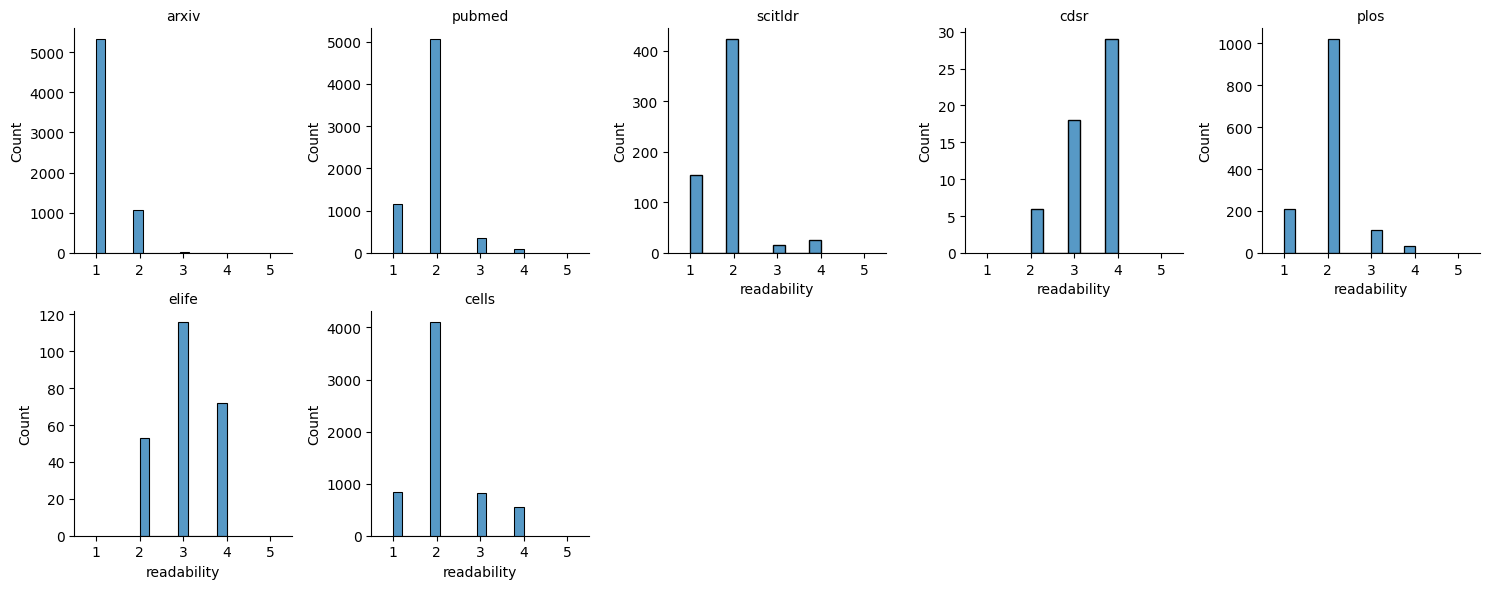

In [51]:
g = sns.FacetGrid(all_scores, 
                col="dataset", 
                col_order=[
                    "arxiv", 
                    "pubmed", 
                    "scitldr",
                    "cdsr", 
                    "plos", 
                    "elife", 
                    "cells", 
                    ],
                sharey=False, 
                sharex=False, 
                xlim=(0.5,5.5), 
                col_wrap=5
                )

# Map the histplot function to each subplot
g.map(sns.histplot, "readability")

# g.refline(x=all_scores["readability"].mean())
g.set_titles(col_template="{col_name}")
# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
summaries_dir = "/scratch4/mdredze1/icachol1/layscisum/targets"
summaries_files = glob.glob(f"{summaries_dir}/*.target")

In [41]:
format_str = """\
Mean: {:0.2f}
Median: {:0.0f}
Max: {:0.0f}
Min: {:0.0f}
Var:{:0.2f}
"""

def get_len(text):
    return len(text.strip().split())

def analyze_texts(texts, return_n_tokens=False):
    n_tokens = np.zeros(len(texts))
    for i, t in enumerate(texts):
        n_tokens[i] = get_len(t)
    if return_n_tokens:
        return n_tokens
    return [np.mean(n_tokens),
        np.median(n_tokens),
        np.max(n_tokens),
        np.min(n_tokens),
        np.var(n_tokens)]
        
def analyze_file(fpath, return_n_tokens=False):
    with open(fpath) as f:
        texts = f.readlines()
    return analyze_texts(texts, return_n_tokens)

In [53]:
col_names = ["dataset", "mean", "median", "max", "min", "var"]
rows = []
for f_name in summaries_files:
    dataset_name = f_name.split('/')[-1].split('.')[-2]
    stats = analyze_file(f_name)
    rows.append([dataset_name]+stats)

df = pd.DataFrame(rows, columns=col_names)
df


,dataset,mean,median,max,min,var
0,scinews,615.017670,571.0,2720.0,119.0,61598.801980
1,elife,383.091286,380.0,607.0,226.0,4361.327766
2,cdsr,221.132075,139.0,696.0,101.0,26451.850481
3,eureka,662.369307,629.5,1628.0,39.0,57528.949751
4,plos,194.696948,202.0,400.0,51.0,1481.026619
5,cells,161.831247,146.0,609.0,41.0,4412.272426
6,scitldr,18.852751,18.0,44.0,3.0,57.203237
7,arxiv,163.130745,159.0,290.0,44.0,3340.795017
8,skj,142.246479,144.0,356.0,72.0,786.446290
9,pubmed,205.383356,213.0,506.0,17.0,6365.603376


In [49]:
all_scores['n_tokens'] = -1
for fpath in summaries_files:
    dataset_name = fpath.split('/')[-1].split('.')[-2]
    ntokens  = analyze_file(fpath, return_n_tokens=True)
    all_scores.loc[all_scores['dataset'] == dataset_name, 'n_tokens'] = ntokens
all_scores

,readability,summary,response,dataset,model,coleman_liau,n_tokens
0,2.0,"Significance Endothelial cells ( ECs) , which ...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct,17.323846,106
1,1.0,Significance Epithelial cellular activating mo...,I would rate the reading ease of this text as ...,cells,3-70B-Instruct,18.534513,114
2,2.0,Significance Approximately 25% of the human pr...,I would rate the reading ease of this text as ...,cells,3-70B-Instruct,14.905455,120
3,2.0,"All cell types have a characteristic size, but...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct,14.680190,212
4,2.0,"Significance Processing of spatial, temporal, ...",I would rate the reading ease of this text as ...,cells,3-70B-Instruct,20.318644,118
...,...,...,...,...,...,...,...
27173,1.0,we explain how hierarchical organization of bi...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct,16.108940,241
27174,4.0,this work presents a smart trespasser detectio...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct,-1.000000,100
27175,2.0,the giant radio galaxy m87 was observed at tev...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct,-1.000000,101
27176,1.0,the discovery of decay products of a short - l...,I would rate the reading ease of this text as ...,arxiv,3-70B-Instruct,12.868313,272


In [ ]:
pearsonr(all_scores['readability'], all_scores['n_tokens'])

PearsonRResult(statistic=0.23042170859930367, pvalue=1.068088971052248e-274)

<Axes: xlabel='readability', ylabel='n_tokens'>

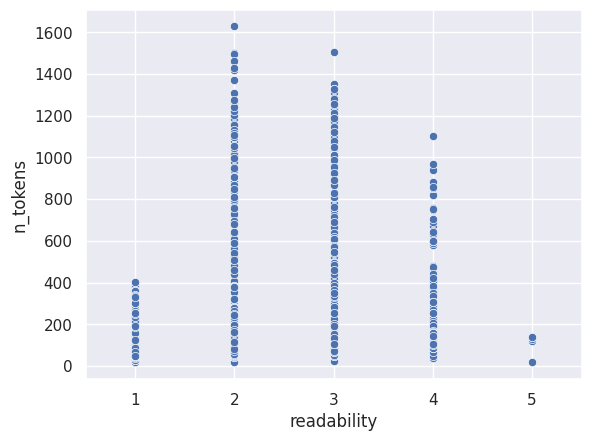

In [ ]:
ax = plt.subplot()
ax.xaxis.set_ticks([1,2,3,4,5])
ax.set_xlim([0.5,5.5])
sns.scatterplot(all_scores, x="readability", y='n_tokens', ax=ax)